In [46]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

/tmp/ipykernel_95295/2008134232.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Data

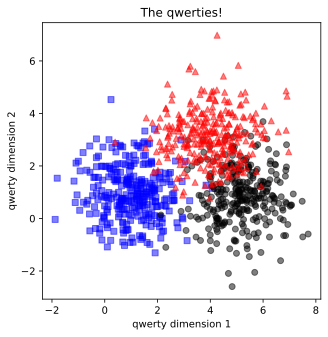

In [47]:
# create data

nPerClust = 300
blur = 1

A = [ 1, 1 ]
B = [ 5, 1 ]
C = [ 4, 3 ]

# generate data
a = [ A[0]+np.random.randn(nPerClust)*blur , A[1]+np.random.randn(nPerClust)*blur ]
b = [ B[0]+np.random.randn(nPerClust)*blur , B[1]+np.random.randn(nPerClust)*blur ]
c = [ C[0]+np.random.randn(nPerClust)*blur , C[1]+np.random.randn(nPerClust)*blur ]

# true labels
labels_np = np.hstack((  np.zeros((nPerClust)),
                         np.ones( (nPerClust)),
                       1+np.ones( (nPerClust))  ))

# concatanate into a matrix
data_np = np.hstack((a,b,c)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long() # note: "long" format for CCE

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs',alpha=.5)
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko',alpha=.5)
plt.plot(data[np.where(labels==2)[0],0],data[np.where(labels==2)[0],1],'r^',alpha=.5)
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [48]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Model

In [49]:
# Create a function and class for the model with specified optimizer and learning rate

# Explanation:
# In this code snippet, we define a function 'createTheQwertyNet' that creates a neural network model with a specific optimizer algorithm and learning rate.

def createTheQwertyNet(optimizerAlgo, learningrate):

    # Explanation:
    # Inside the function, we define a neural network class 'qwertyNet' that inherits from nn.Module. This class represents our model architecture.

    class qwertyNet(nn.Module):
        def __init__(self):
            super().__init__()

            ### Input layer
            self.input = nn.Linear(2, 8)

            ### Hidden layer
            self.fc1 = nn.Linear(8, 8)

            ### Output layer
            self.output = nn.Linear(8, 3)

        # Forward pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            return self.output(x)

    # Explanation:
    # We create an instance of the 'qwertyNet' class, representing our neural network model.

    net = qwertyNet()

    # Loss function
    lossfun = nn.CrossEntropyLoss()

    # Explanation:
    # We define the loss function to be used during training, which is Cross-Entropy Loss in this case.

    # Optimizer
    optifun = getattr(torch.optim, optimizerAlgo)
    optimizer = optifun(net.parameters(), lr=learningrate)

    # Explanation:
    # We specify the optimizer algorithm by dynamically selecting it based on the 'optimizerAlgo' argument.
    # We also set the learning rate for the optimizer.

    return net, lossfun, optimizer

# Explanation:
# The function 'createTheQwertyNet' returns the neural network model, the loss function, and the optimizer with the specified algorithm and learning rate.


# Training

In [50]:
# a function that trains the model

def function2trainTheModel(optimizerType,learningrate,train_loader,test_loader):

  # number of epochs
  numepochs = 50
  
  # create a new model
  net,lossfun,optimizer = createTheQwertyNet(optimizerType,learningrate)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    net.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100 
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) ) 
  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


# Experiment

In [51]:
# Variables to loop over
# learningRates = np.logspace(np.log10(.0001), np.log10(.1), 20)
learningRate = .01
optimTypes = ['SGD', 'RMSprop', 'Adam']

# finally, translate into dataloader objects
batchSizes    = [2**i for i in range(3, 8)]  # 8, 16, 32, 64, 128

# Explanation:
# In this code snippet, we define a range of learning rates and a list of optimizer types to be tested in an experiment.

# Initialize performance matrix
finalPerformance = np.zeros((len(batchSizes), len(optimTypes)))

# Explanation:
# We initialize a matrix called 'finalPerformance' with dimensions (number of learning rates, number of optimizer types) to store the results of an experiment. Each row corresponds to a different learning rate, and each column corresponds to a different optimizer type.

# Now for the experiment!
for idx_b, batchsize in enumerate(batchSizes):
    train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
    test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])
    
    for idx_o, opto in enumerate(optimTypes): 
        # Explanation:
        # We iterate through each combination of optimizer type and learning rate to conduct an experiment. Inside the loop, we call a function (presumably 'function2trainTheModel') to train a neural network model with the specified optimizer type and learning rate.

        trainAcc, testAcc, losses, net = function2trainTheModel(opto, learningRate, train_loader, test_loader)

        # Explanation:
        # We store the training accuracy, test accuracy, and loss values obtained during training.

        finalPerformance[idx_b, idx_o] = np.mean(testAcc[:10])

        # Explanation:
        # We compute the mean test accuracy of the last 10 data points from the 'testAcc' list and store it in the 'finalPerformance' matrix.

# Explanation:
# After the loop completes, the 'finalPerformance' matrix contains the average test accuracy values for different combinations of learning rates and optimizer types, providing insights into the performance of different configurations in the experiment.


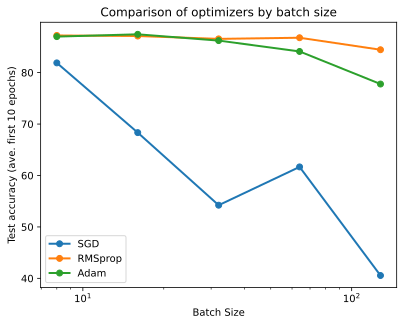

In [52]:
# plot the results! 
plt.plot(batchSizes,finalPerformance,'o-',linewidth=2)
plt.legend(optimTypes)
plt.xscale('log')
plt.xlabel('Batch Size')
plt.ylabel('Test accuracy (ave. first 10 epochs)')
plt.title('Comparison of optimizers by batch size')
plt.show()

# Optional explorations

In [53]:
# 1) Which optimizer is best for quick learning? Re-run the code but average accuracy in the FIRST 10 training epochs 
#    instead of the FINAL 10 training epochs.
# 
# 2) Similar question but for batch size. Try using batch sizes ranging from 2**4 (16) to 2**7 (128).
# 